# Run stack on mosaic of trailed sources

using https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/Measurement/UndersampledMoments.nbconvert.ipynb

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
import lsst.daf.persistence as afwPersist
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
import lsst.afw.math as afwMath
import lsst.geom as afwGeom
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.ip.isr.isrFunctions import updateVariance
import lsst.meas.extensions.trailedSources

#%run -i streaks/streaks.py

np.random.seed(134)
afwDisplay.setDefaultBackend('matplotlib')
%matplotlib inline

In [2]:
# streaks.py

def psf_kernel(x0, y0, xdim, ydim, sigma):
    """
    Point-spread function convolution kernel. 
    Double guassian, centered at x0,y0.
    """
    
    # Pixel locations, center at 0,0
    x = np.arange(-xdim//2 + 1, xdim//2 + 1) - x0
    y = np.arange(-ydim//2 + 1, ydim//2 + 1) - y0
    
    # Calculate psf over each pixel
    r = np.sqrt((x[None, :])**2 + (y[:, None])**2)
    psf = np.exp(-r**2./2./sigma**2.) / (2*np.pi*sigma**2.)
    
    return psf

def make_image(F, x, y, xdim, ydim, noise=False, b = 0, sigma = 1.5):
    """Generate image from using psf_kernel"""
    #image = np.zeros((ydim,xdim))
    image = F * psf_kernel(x,y,xdim,ydim,sigma) + b
    
    # Add poisson noise if desired
    if noise: image = np.random.poisson(image);
    
    return image 

def make_trailed_image(params, xdim, ydim, npts = None, noise=False, b = 0, sigma = 1.5):
    """
    Generate trailed source image.
    Integrate a psf over path.
    """
    F,xh,yh,xt,yt = params
    image = np.zeros((ydim,xdim))
    
    # Choose npts adaptively
    if npts == None: npts = int(np.sqrt((xh - xt)**2 + (yh - yt)**2));
    
    # Line of source points 
    xs = np.linspace(xh,xt,npts)
    ys = np.linspace(yh,yt,npts)
    
    # Evaluate trailed image model at each 'source' center
    # xs and ys flipped in image
    for i in range(xs.size):
        image += make_image(1,xs[i],ys[i],xdim,ydim,sigma=sigma) 
    
    # Apply total flux and background to image
    image = F * (image / image.sum()) + b
    
    # Add poisson noise if desired
    if noise: image = np.random.poisson(image)
    
    return image

def chi_squared(params, data, sigma = 1.5, npts=10):
    """Calculate chi-squared of data - trailed-source model."""
    xdim, ydim = data.shape
    model = make_trailed_image(params, xdim, ydim, sigma=sigma, npts=npts)
    return np.sum((data - model)**2. / error)

def plotCutout(img, title = None, clabel='$counts$', xlabel='x (pixels)', ylabel='y (pixels)', loc=None, fig=None, clim=(-60, 300)):
    """Make a nice looking plot of a small image"""
    if loc is None:
        fig, ax = plt.subplots(figsize=(8,8))
        fig.subplots_adjust(right=0.8, bottom=0.34)
    else:
        ax = fig.add_subplot(loc)

    # coordinate of the edge (assuming a square image)
    xe = img.shape[0] // 2.

    if title is None:
        title = "min = %.1f, max=%.1f" % (img.min(), img.max())
    
    ax.set_title(title, fontsize=14)
    plt.imshow(img, origin='lower', interpolation='nearest',
           extent=(-xe, xe, -xe, xe),
           cmap=plt.cm.binary, aspect='auto')
    plt.clim(*clim)
    plt.colorbar().set_label(clabel)

    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)

In [3]:
class TrailedSourceSim:

    def __init__(self, stamp_width=25, sky_noise=500, sigma = 1.5):
        self.stamp_width=stamp_width
        self.sky_noise=sky_noise
        self.sigma = sigma
    
    def draw_trail(self, offset=(0.0,0.0), length=1.0, angle=np.pi/4, flux=1000):
        """Draw a trailed source on image"""
        x_h = offset[0] - length/2 * np.cos(angle)
        y_h = offset[1] - length/2 * np.sin(angle)
        x_t = offset[0] + length/2 * np.cos(angle)
        y_t = offset[1] + length/2 * np.sin(angle)
        params = np.array([flux, x_h, y_h, x_t, y_t])
        sim = make_trailed_image(params, self.stamp_width, self.stamp_width, noise=True, b=self.sky_noise, sigma=self.sigma, npts=10)
        return sim

    def make_input_catalogue(self, n_per_side=5, offsetx_minmax=(-0.5,0.5),offsety_minmax=(-0.5,0.5),
                        angle_minmax=(0.0,2*np.pi),len_minmax=(3,15),flux_minmax=(80000,15000)):
        """Make input catalogue of sources"""
        n_stamps = n_per_side**2
        cat_in = np.zeros(n_stamps, dtype={'names':('x','y','x_sub','y_sub','angle','length','flux'),
                                      'formats':('f8','f8','f8','f8','f8','f8','f8')})
        cat_in['x_sub']=np.linspace(offsetx_minmax[0], offsetx_minmax[1], n_stamps)
        cat_in['y_sub']=np.linspace(offsety_minmax[0], offsety_minmax[1], n_stamps)
        cat_in['length']=np.linspace(len_minmax[0], len_minmax[1], n_stamps)
        cat_in['angle']=np.linspace(angle_minmax[0], angle_minmax[1], n_stamps)
        cat_in['flux']=np.linspace(flux_minmax[0], flux_minmax[1], n_stamps)
        return cat_in

    def make_mosaic(self, cat_in):
        """Make mosaic of postage stamps"""
        n_stamps = len(cat_in)
        n_per_side=np.int(np.floor(np.sqrt(n_stamps)))
        mosaic_width = n_per_side*self.stamp_width
        mosaic = np.empty((mosaic_width, mosaic_width))
        mosaic[:] = np.nan
        for i in range(n_per_side):
            for j in range(n_per_side):
                k=i+j*n_per_side
                sim = self.draw_trail(offset=(cat_in['x_sub'][k], cat_in['y_sub'][k]),
                                     length=cat_in['length'][k], angle=cat_in['angle'][k],
                                     flux=cat_in['flux'][k])
            
                w = self.stamp_width
                mosaic[j*w:(j+1)*w, i*w:(i+1)*w] = sim
                cat_in['x'][k] = (i+.5)*w + cat_in['x_sub'][k] - 0.5
                cat_in['y'][k] = (i+.5)*w + cat_in['y_sub'][k] - 0.5
    
        return mosaic, cat_in

In [4]:
# Set up simulator
stamp_width= 63
skybg = 900.0
sigma = 1.27
sim = TrailedSourceSim(stamp_width,skybg,sigma)

In [5]:
# Make catalogue
n_per_side = 2
offsetx_minmax=(5,5)
offsety_minmax=(5,5)
angle_minmax=(0.,np.pi/2)
len_minmax=(5,20)
flux_minmax=(41000,41000)
cat_in = sim.make_input_catalogue(n_per_side=n_per_side,
                                  offsetx_minmax=offsetx_minmax,
                                  offsety_minmax=offsety_minmax,
                                  angle_minmax=angle_minmax,
                                  len_minmax=len_minmax,
                                  flux_minmax=flux_minmax)

In [6]:
mosaic, cat_in = sim.make_mosaic(cat_in)

In [7]:
# Calculate signal to noise
F = flux_minmax[0] / len_minmax[0]
noise = 26.0
fwhm = 2.335 * 1.5
print("Approx. SNR: ", F * 0.66 / np.sqrt(skybg + noise**2) / fwhm)

Approx. SNR:  38.92257260108011


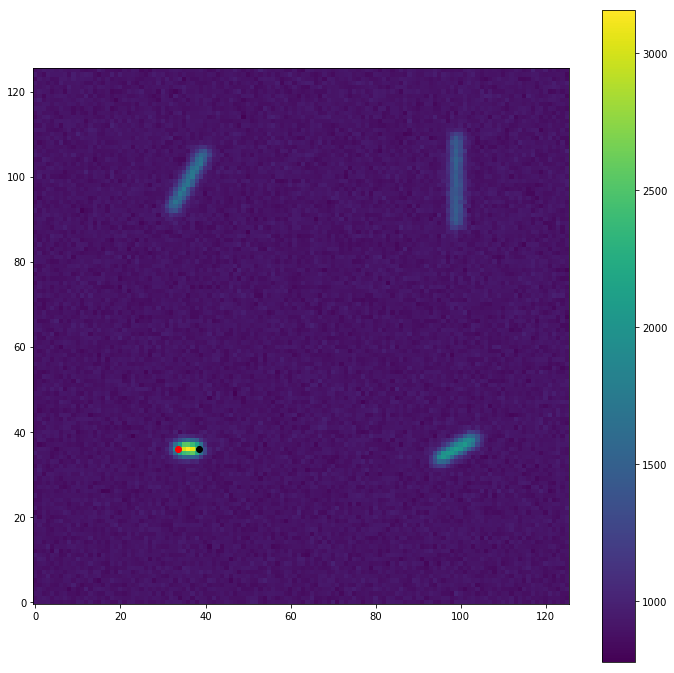

In [8]:
plt.figure(figsize=(12,12))
plt.imshow(mosaic, origin='lower'),plt.colorbar()
si = 0
x0 = offsetx_minmax[si] + ((stamp_width + 0) // 2) - (len_minmax[si] / 2) * np.cos(angle_minmax[si])
y0 = offsety_minmax[si] + ((stamp_width + 0) // 2) - (len_minmax[si] / 2) * np.sin(angle_minmax[si])
x1 = offsetx_minmax[si] + ((stamp_width + 0) // 2) + (len_minmax[si] / 2) * np.cos(angle_minmax[si])
y1 = offsety_minmax[si] + ((stamp_width + 0) // 2) + (len_minmax[si] / 2) * np.sin(angle_minmax[si])
plt.scatter([x0],[y0],color='red')
plt.scatter([x1],[y1],color='k')

In [9]:
# Output to fits file
data_dir = '/home/langfzac/test/test_trailedSources/DATA/'
if not os.path.exists(data_dir):
    ! mkdir /home/langfzac/DATA/trailed
fits.writeto(data_dir+'trailed_mosaic.fits', mosaic, overwrite=True)

In [10]:
def stack_char_and_cal_catalogue(fitsfilename, skybg, noise):
    from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
    from lsst.pipe.tasks.calibrate import CalibrateTask
    from lsst.meas.base import SingleFrameMeasurementTask
    import lsst.afw.image as afwImage
    import lsst.meas.extensions.trailedSources
    
    # Characterize task
    charConfig = CharacterizeImageTask.ConfigClass()
    charConfig.installSimplePsf.fwhm = 3.#.05
    charConfig.doMeasurePsf = False
    charConfig.doApCorr = False # necessary
    charConfig.repair.doCosmicRay = False
    charConfig.detection.background.binSize = 20
    charConfig.detection.minPixels = 5
    charConfig.measurement.plugins.names |= ['ext_trailedSources_Naive']
    charConfig.measurement.plugins.names |= ['ext_trailedSources_Convolved']
    #charConfig.measurement.plugins['ext_trailedSources_TrailedSource'].optimizerMaxIter = 5000
    charTask = CharacterizeImageTask(config=charConfig)
    
    # Calibration task
    calConfig = CalibrateTask.ConfigClass()
    calConfig.doAstrometry = False
    calConfig.doPhotoCal = False
    calConfig.doApCorr = False
    calConfig.doDeblend = False
    calConfig.detection.background.binSize = 50
    calConfig.detection.minPixels = 5
    #calConfig.measurement.plugins.names |= ['ext_trailedSources_Naive']
    #calConfig.measurement.plugins.names |= ['ext_trailedSources_Convolved']
    #calConfig.measurement.plugins['ext_trailedSources_TrailedSource'].optimizerMaxIter = 5000
    
    # Read in mosaic image and convert
    image_array=afwImage.ImageF.readFits(fitsfilename)
    image = afwImage.ImageF(image_array)
    exposure = afwImage.ExposureF(image.getBBox())
    exposure.setImage(image)
    im = exposure.getImage()
    im -= skybg # Remove sky background
    # Add variance
    var = exposure.getVariance()
    var += noise**2

    charResult = charTask.run(exposure)
    print("Characterize completed...")
    #calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)
    #calResult = calTask.run(charResult.exposure, background=charResult.background, 
    #                        icSourceCat = charResult.sourceCat)
    #print("Calibrate completed...")

    return charResult.sourceCat, exposure

In [11]:
cat_stack, calexp = stack_char_and_cal_catalogue(data_dir+'trailed_mosaic.fits', skybg, noise)

Characterize completed...


In [12]:
# display source measurements by keyword
def peak_schema(src, keyword):
    names=[]
    for name in src.schema.getOrderedNames():
        if keyword in name.lower():
            names.append(str(name)+': '+str(src[name]))
    return names

In [13]:
#[print(peak_schema(cat_stack[i],'chi_squared')) for i in range(len(cat_stack))];
peak_schema(cat_stack[0],'trail')

['ext_trailedSources_Naive_x0: 95.50747795250577',
 'ext_trailedSources_Naive_y0: 34.08331383008222',
 'ext_trailedSources_Naive_x1: 102.44616022721358',
 'ext_trailedSources_Naive_y1: 38.07524659919166',
 'ext_trailedSources_Naive_flux: 40099.38986766338',
 'ext_trailedSources_Naive_flag: False',
 'ext_trailedSources_Convolved_x0: 94.22343548860748',
 'ext_trailedSources_Convolved_y0: 33.25189778832772',
 'ext_trailedSources_Convolved_x1: 103.74028292203904',
 'ext_trailedSources_Convolved_y1: 38.70958789068791',
 'ext_trailedSources_Convolved_flux: 3206.3462835108685',
 'ext_trailedSources_Convolved_flag: False']

In [14]:
cat_stack.asAstropy()['ext_trailedSources_Convolved_flux']

3206.3462835108685
3228.4577685010686
3216.174497126933
3250.6283064272243


<Figure size 432x288 with 0 Axes>

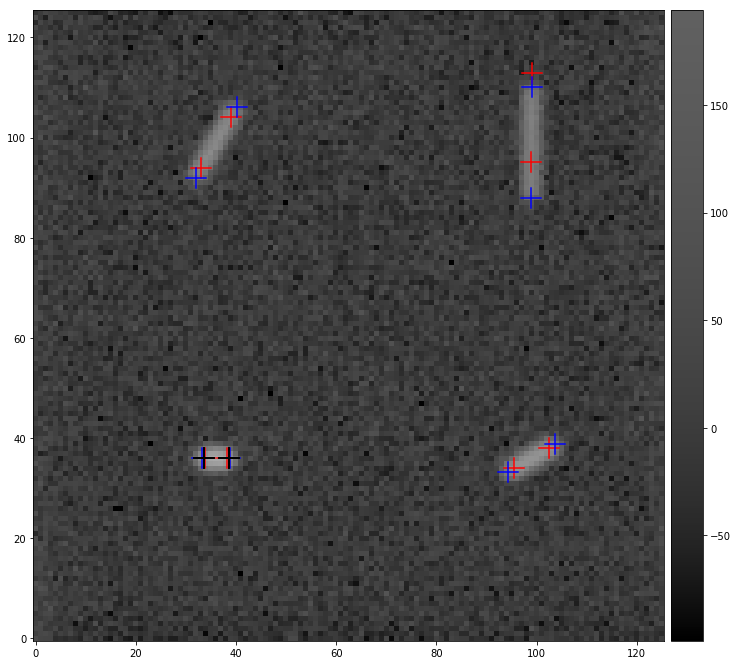

In [15]:
plt.figure()
plt.rcParams['figure.figsize'] = (12.0, 12.0)
afw_display = afwDisplay.Display()
afw_display.scale('asinh','zscale')
afw_display.mtv(calexp.image)
plt.gca()#.axis('off')

for ind in range(n_per_side**2):
    x_h_n = cat_stack[ind]['ext_trailedSources_Naive_x0']
    y_h_n = cat_stack[ind]['ext_trailedSources_Naive_y0']
    x_t_n = cat_stack[ind]['ext_trailedSources_Naive_x1']
    y_t_n = cat_stack[ind]['ext_trailedSources_Naive_y1']
    x_h_fit = cat_stack[ind]['ext_trailedSources_Convolved_x0']
    y_h_fit = cat_stack[ind]['ext_trailedSources_Convolved_y0']
    x_t_fit = cat_stack[ind]['ext_trailedSources_Convolved_x1']
    y_t_fit = cat_stack[ind]['ext_trailedSources_Convolved_y1']
    afw_display.dot('+', x_t_n, y_t_n, size=2, ctype='red')
    afw_display.dot('+', x_h_n, y_h_n, size=2, ctype='red')
    afw_display.dot('+', x_t_fit, y_t_fit, size=2, ctype='blue')
    afw_display.dot('+', x_h_fit, y_h_fit, size=2, ctype='blue')
    afw_display.dot('+', x0, y0, size=2, ctype='k')
    afw_display.dot('+', x1, y1, size=2, ctype='k')

In [16]:
from lsst.meas.extensions.trailedSources import ConvolvedTrailedSourceAlgorithm as CTSA
from lsst.meas.extensions.trailedSources import ConvolvedTrailedSourceControl as CTSC

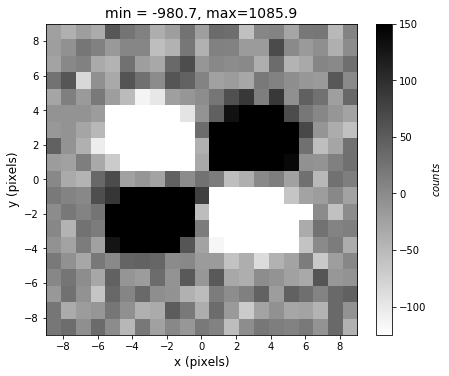

In [17]:
c = CTSA(CTSC(),"test_ext", cat_stack.schema)

ind = 0 # Which source
fp = cat_stack[ind].getFootprint()
cutout = calexp.Factory(calexp, fp.getBBox(), origin=afwImage.LOCAL, deep=False)
data = cutout.image.array
model = c.computeModelImage(cat_stack[ind], calexp).array

plotCutout(data - model, clim=(-125,150))

Flux:  39836.4


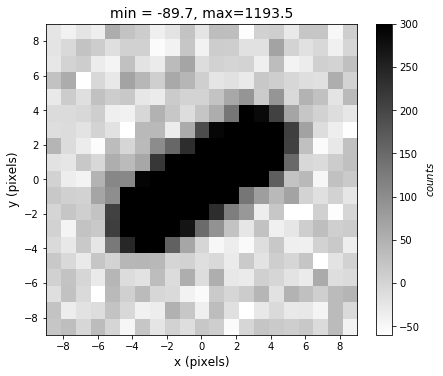

In [18]:
plotCutout(data)
print("Flux: ", np.sum(data))

Flux:  40955.89083530274


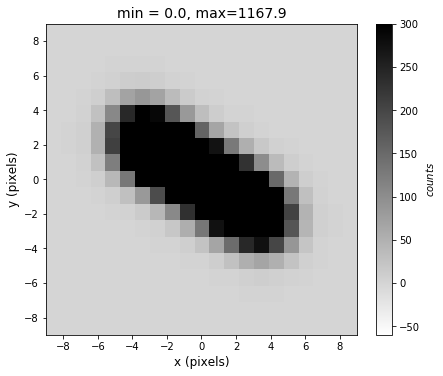

In [19]:
plotCutout(model)
print("Flux: ", np.sum(model))